In [1]:
import os
from aerobot.io import load_results_dict, RESULTS_PATH
import matplotlib.pyplot as plt
from aerobot.plot import plot_configure_mpl
from matplotlib.gridspec import GridSpec
from aerobot.dataset import dataset_load_training_testing_validation 
import pandas as pd 
import numpy as np 

%load_ext autoreload
%autoreload 2

plot_configure_mpl(figure_height=1)

In [18]:
datasets  = dataset_load_training_testing_validation(feature_type='KO', to_numpy=False) # Feature type doesn't matter, as we just want the labels. 
dataset_labels = {k:v['labels'] for k, v in datasets.items()}

phyla = np.unique(np.concatenate([l['Phylum'].values for l in dataset_labels.values()]))

phyla_counts_df = pd.DataFrame()
phyla_counts_df['phylum'] = phyla
phyla_counts_df = phyla_counts_df.set_index('phylum')

for dataset_type, dataset_type_labels in dataset_labels.items():
    counts = dataset_type_labels['Phylum'].value_counts().to_dict()
    phyla_counts_df[dataset_type] = [counts.get(phylum, 0) for phylum in phyla]

phyla_counts_df['total'] = phyla_counts_df.values.sum(axis=1)
phyla_counts_df = phyla_counts_df.sort_values('total', ascending=False)

labels = ['aerobe', 'anaerobe', 'facultative']
labels_counts_df = pd.DataFrame()
labels_counts_df['label'] = labels
labels_counts_df = labels_counts_df.set_index('label')

for dataset_type, dataset_type_labels in dataset_labels.items():
    counts = dataset_type_labels['physiology'].value_counts().to_dict()
    labels_counts_df[dataset_type] = [counts.get(label, 0) for label in labels]
    labels_counts_df[dataset_type] = labels_counts_df[dataset_type] / labels_counts_df[dataset_type].sum() # Convert to fractions. 
    

# SI Figure 1

In [27]:
def plot_si_figure_1a(phyla_counts_df, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plot a barplot showing the twenty most common phyla in the training and validation datasets.'''

    ax = fig.add_subplot(grid)
    n_phyla = len(phyla_counts_df)

    kwargs = {'edgecolor':'k', 'lw':0.5}
    bottom = np.zeros(n_phyla)
    for dataset_type in ['training', 'testing', 'validation']:
        ax.bar(np.arange(n_phyla), phyla_counts_df[dataset_type].values, bottom=bottom, **kwargs)
        bottom += phyla_counts_df[dataset_type].values 

    ax.set_xticks(np.arange(n_phyla), labels=phyla_counts_df.index, rotation=90)
    ax.legend(['training data', 'testing data', 'validation data'])
    ax.set_ylabel('number of genomes')

    ax.set_title('phylogenetic coverage')

    return ax


In [28]:
def plot_si_figure_1b(labels_counts_df, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plot a stacked barplot showing the makeup of the training and validation datasets, i.e. how many instances
    of each metabolic category are present in each dataset.'''

    ax = fig.add_subplot(grid)
    ax.set_title('dataset composition')

    kwargs = {'edgecolor':'k', 'lw':0.5}
    ax.bar(np.arange(3), labels_counts_df.iloc[0].values, **kwargs)
    ax.bar(np.arange(3), labels_counts_df.iloc[1].values, bottom=labels_counts_df.iloc[0].values, **kwargs)
    ax.bar(np.arange(3), labels_counts_df.iloc[2].values, bottom=labels_counts_df.iloc[0:2].values.sum(axis=0), **kwargs)

    ax.set_xticks(np.arange(3), labels=labels_counts_df.columns)
    ax.legend(['aerobe', 'anaerobe', 'facultative'])
    ax.set_ylabel('proportion')

    return ax


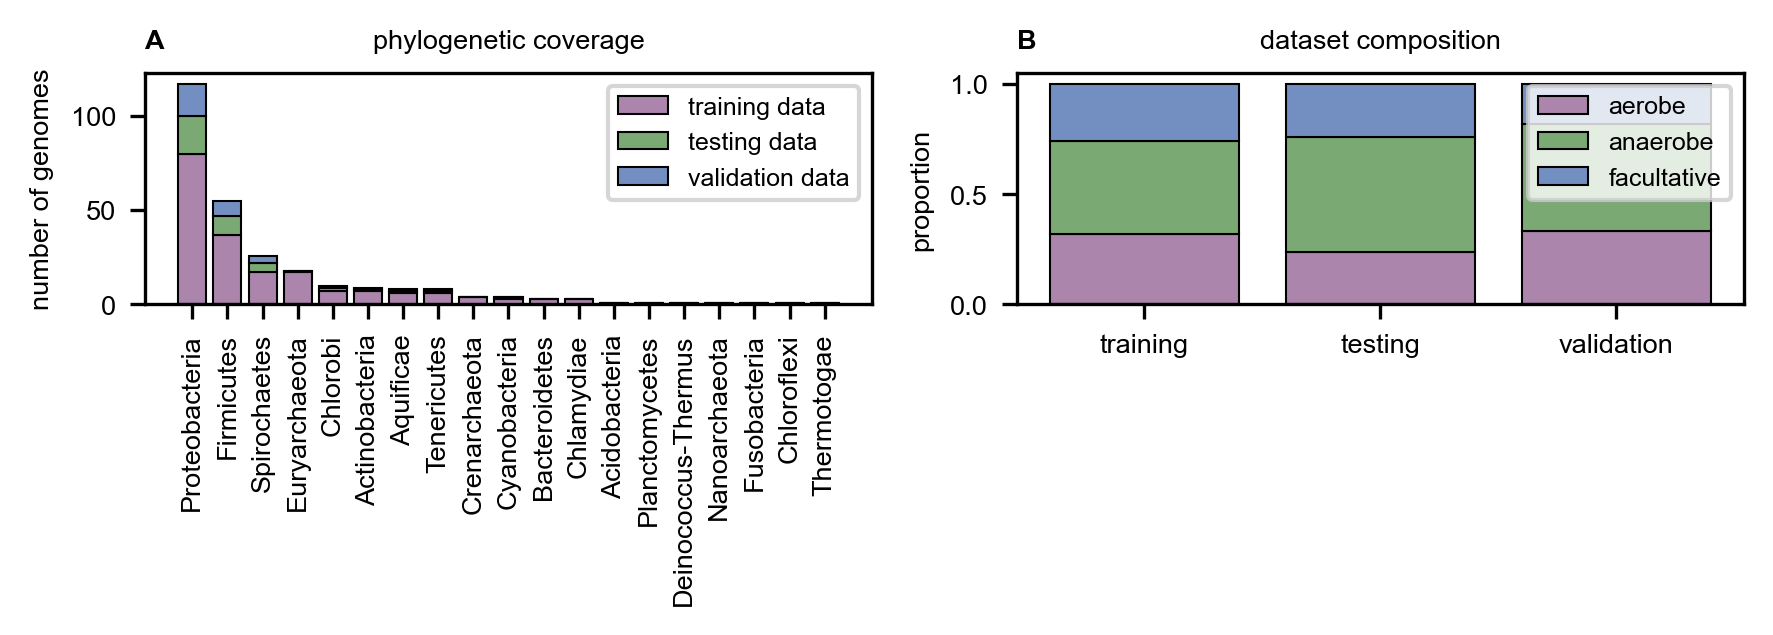

In [29]:
fig = plt.figure()
grid = GridSpec(1, 2, wspace=0.2) 

axes = []
axes.append(plot_si_figure_1a(phyla_counts_df, grid=grid[0, 0], fig=fig))
axes.append(plot_si_figure_1b(labels_counts_df, grid=grid[0, 1], fig=fig))

for ax, ax_label in zip(axes, 'AB'):
    ax.set_title(ax_label, loc='left', fontweight='bold')

plt.savefig('../results/figures/si_fig1.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()
